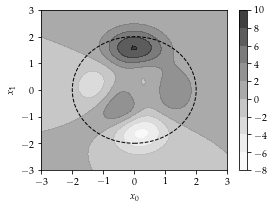

In [1]:
import numpy as np
import pandas as pd
import pyomo.environ as pyo
import time
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, precision_score, recall_score

from oodx import DataBlock, GPR, GPC, NN, MPBlock, AdaptiveSampler
from utils import (
    BlackBox, plot_underlying, plot_samples, plot_gpr, plot_gpc, plot_gp_opt, plot_gp_adaptive_opt, plot_nnr,
    plot_nnc, plot_nn_opt, plot_nn_adaptive_opt, plot_bayesian_opt, plot_direct_search
)

plot_underlying()

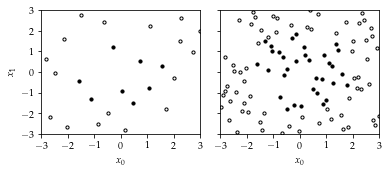

In [2]:
bb = BlackBox()
space = [[-3.0, 3.0], [-3.0, 3.0]]

db = DataBlock(inputs=['x0', 'x1'], outputs=['y'], targets=True)
db.static_sample(25, space)
db.data.y = bb.sample_y(db.data[['x0', 'x1']].values)
db.data.t = bb.sample_t(db.data[['x0', 'x1']].values)

db2 = DataBlock(inputs=['x0', 'x1'], outputs=['y'], targets=True)
db2.static_sample(100, space)
db2.data.y = bb.sample_y(db2.data[['x0', 'x1']].values)
db2.data.t = bb.sample_t(db2.data[['x0', 'x1']].values)

db3 = DataBlock(inputs=['x0', 'x1'], outputs=['y'], targets=True)
db3.static_sample(500, space)
db3.data.y = bb.sample_y(db3.data[['x0', 'x1']].values)
db3.data.t = bb.sample_t(db3.data[['x0', 'x1']].values)

plot_samples(db, db2)
plt.savefig('../figures/samples.png', dpi=500)

In [24]:
print(len(db.data[db.data.t==1]))
print(len(db2.data[db2.data.t==1]))

8
33


1.1760994416349397
0.064588650035436


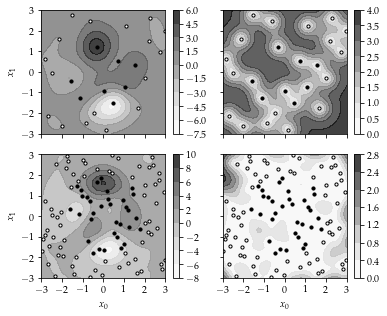

In [3]:
gpr = GPR()
gpr.fit(db.scaled_inputs.to_numpy(), db.scaled_outputs.to_numpy(), iprint=0)
pred = gpr.predict(db.scale_inputs(db3.data[['x0', 'x1']]).to_numpy())
print(mean_absolute_error(db3.data.y[db3.data.t==1], db.inv_scale_outputs(pred)[db3.data.t==1]))

gpr2 = GPR()
gpr2.fit(db2.scaled_inputs.to_numpy(), db2.scaled_outputs.to_numpy(), iprint=0)
pred2 = gpr2.predict(db2.scale_inputs(db3.data[['x0', 'x1']]).to_numpy())
print(mean_absolute_error(db3.data.y[db3.data.t==1], db2.inv_scale_outputs(pred2)[db3.data.t==1]))

plot_gpr(db, db2, gpr, gpr2)
plt.savefig('../figures/gpr.png', dpi=500)

0.9693251533742331 0.8633879781420765
0.9661016949152542 0.9344262295081968


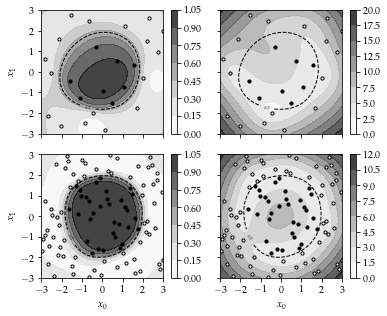

In [4]:
gpc = GPC()
gpc.fit(db.scaled_inputs.to_numpy(), db.data.t.to_numpy().reshape(-1, 1), iprint=0)
pred = gpc.predict(db.scale_inputs(db3.data[['x0', 'x1']]).to_numpy(), return_class=True)[1]
precision = precision_score(db3.data.t.to_numpy(), pred)
recall = recall_score(db3.data.t.to_numpy(), pred)
print(precision, recall)

gpc2 = GPC()
gpc2.fit(db2.scaled_inputs.to_numpy(), db2.data.t.to_numpy().reshape(-1, 1), iprint=0)
pred = gpc2.predict(db2.scale_inputs(db3.data[['x0', 'x1']]).to_numpy(), return_class=True)[1]
precision = precision_score(db3.data.t.to_numpy(), pred)
recall = recall_score(db3.data.t.to_numpy(), pred)
print(precision, recall)

plot_gpc(db, db2, gpc, gpc2)
plt.savefig('../figures/gpc.png', dpi=500)

In [5]:
def pyomo_problem(space, p):
    m = pyo.ConcreteModel()
    m.n_inputs = set(range(len(space)))
    m.inputs = pyo.Var(m.n_inputs, bounds=space)
    m.output = pyo.Var()
    m.prob = pyo.Var()
    m.feasibility_con = pyo.Constraint(expr= m.prob >= p)
    m.obj = pyo.Objective(expr=m.output, sense=pyo.maximize)
    return m

def gp_algorithm_results(m, d, gp, testing, t):
    results = pd.Series(dtype='float64')
    x = np.fromiter(m.inputs.extract_values().values(), dtype=float).reshape(1, -1)
    results['x0*'] = d.inv_scale_inputs(x).ravel()[0]
    results['x1*'] = d.inv_scale_inputs(x).ravel()[1]
    results['obj'] = d.inv_scale_outputs(np.array(m.output.value).reshape(1, -1)).ravel()[0]
    results['prob'] = m.prob.value
    results['err'] = mean_absolute_error(testing.data.y[testing.data.t==1], d.inv_scale_outputs(gp.predict(d.scale_inputs(testing.data[['x0', 'x1']]).to_numpy()))[testing.data.t==1])
    results['unc'] = 1.96 * d.std_outputs.to_numpy().ravel()[0] * gp.predict(x, return_std=1)[1].ravel()[0]
    results['tsol'] = t[2] - t[1]
    results['ttot'] = t[2] - t[0]
    return results

def gp_global_dfo(db, gpr, gpc, solver, testing):
    times = [time.time()]
    omo = pyomo_problem(db.scaled_space, 0.5)

    gpr_block = MPBlock(gpr)
    gpc_block = MPBlock(gpc)
    omo.gpr = gpr_block.get_formulation()
    omo.gpc = gpc_block.get_formulation()

    omo.connectors = pyo.ConstraintList()
    omo.connectors.add(omo.output == omo.gpr.outputs[0])
    omo.connectors.add(omo.prob == omo.gpc.outputs[0])
    for i in omo.n_inputs:
        omo.connectors.add(omo.inputs[i] == omo.gpr.inputs[i])
        omo.connectors.add(omo.inputs[i] == omo.gpc.inputs[i])

    times.append(time.time())
    solver.solve(omo, tee=True)
    times.append(time.time())

    results = gp_algorithm_results(omo, db, gpr, testing, times)
    
    return results

 BARON version 22.9.30. Built: OSX-64 Fri Sep 30 09:08:44 EDT 2022

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Benoit Chachuat at Imperial College London, b.chachuat@imperial.ac.uk.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Khajavirad, A. and N. V. Sahinidis,
 A hybrid LP/NLP paradigm for global optimization relaxations,
 Mathematical Programming Computation, 10, 383-421, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC, ILOG CPLEX                             
 For NLP: IPOPT, FILTERSQP
 Doing local search
 Preprocessing found feasible solution with value 1.47656
 Solving bounding LP
 Starting multi-start local search
 Done with local search
  Iteration    Open nodes         Time (s)    Lower bound      Upper bound
          1             1            17.12      1.47656          4.52048
         49             

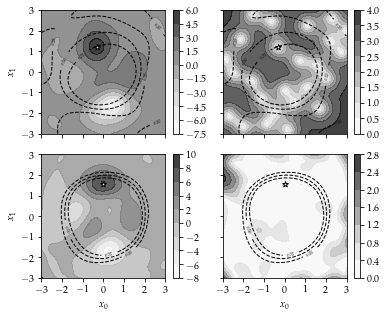

In [6]:
solver = pyo.SolverFactory('baron')
# solver.options['MaxTime'] = 120
results1 = gp_global_dfo(db, gpr, gpc, solver, db3)
results2 = gp_global_dfo(db2, gpr2, gpc2, solver, db3)

plot_gp_opt(db, db2, gpr, gpr2, gpc, gpc2, results1[['x0*', 'x1*']], results2[['x0*', 'x1*']])
plt.savefig('../figures/gpopt.png', dpi=500)

print(results1)
print(results2)

In [7]:
def dim_convergence_check(bounds, tol):
    if bounds[1] - bounds[0] <= tol:
        print('dimension converged')
        return 1
    else:
        return 0
    
def convergence_check(space, tol):
    checks = []
    for dim, bounds in enumerate(space):
        if dim_convergence_check(bounds, tol):
            checks.append(1)
    if len(checks) == len(space):
        print('converged')
        return 1
    else:
        return 0

def bt(space0, space, shrink, sol, tol, prox=0.001):
    for dim, (lb, ub) in enumerate(space):
        if dim_convergence_check(space[dim], tol) == 1:
            space[dim] = [sol[dim] - tol / 2, sol[dim] + tol / 2]
        elif sol[dim] <= lb + prox:
            print('lower bound active')
            space[dim] = [sol[dim] - (ub - lb) / 2, sol[dim] + (ub - lb) / 2]
        elif sol[dim] >= ub - prox:
            print('upper bound active')
            space[dim] = [sol[dim] - (ub - lb) / 2, sol[dim] + (ub - lb) / 2]
        else:
            print('shrinking dimension...')
            new_size = (ub - lb) * shrink
            space[dim] = [sol[dim] - new_size / 2, sol[dim] + new_size / 2]
    return space

def gp_adaptive_results(m, d, gp, testing, t):
    results = pd.Series(dtype='float64')
    x = np.fromiter(m.inputs.extract_values().values(), dtype=float).reshape(1, -1)
    results['x0*'] = d.inv_scale_inputs(x).ravel()[0]
    results['x1*'] = d.inv_scale_inputs(x).ravel()[1]
    results['obj'] = d.inv_scale_outputs(np.array(m.output.value).reshape(1, -1)).ravel()[0]
    results['prob'] = m.prob.value
    results['err'] = mean_absolute_error(testing.y[testing.t==1], d.inv_scale_outputs(gp.predict(d.scale_inputs(testing[['x0', 'x1']]).to_numpy()))[testing.t==1])
    results['unc'] = 1.96 * d.std_outputs.to_numpy().ravel()[0] * gp.predict(x, return_std=1)[1].ravel()[0]
    results['tads'] = t[2] - t[1]
    results['tomo'] = t[4] - t[3]
    results['ttot'] = t[5] - t[0]
    return results

def gp_adaptive_dfo(space, d, gpr, gpc, max_iter, solver, testing):
    for iteration in range(max_iter):
        times = [time.time()]
        
        gpr_block = MPBlock(gpr)
        gpc_block = MPBlock(gpc)
        
        omo = pyomo_problem(d.scale_space(space), 0.5)
        omo.gpr = gpr_block.get_formulation()
        omo.gpc = gpc_block.get_formulation()
        omo.connectors = pyo.ConstraintList()
        omo.connectors.add(omo.output == omo.gpr.outputs[0])
        omo.connectors.add(omo.prob == omo.gpc.outputs[0])
        for i in omo.n_inputs:
            omo.connectors.add(omo.inputs[i] == omo.gpr.inputs[i])
            omo.connectors.add(omo.inputs[i] == omo.gpc.inputs[i])
            
        ads = AdaptiveSampler(d.scale_space(space))
        mod = ads.max_gp_std(gpr)
        mod.gpc = gpc_block.get_formulation()
        mod.feas = pyo.Constraint(expr=mod.gpc.outputs[0] >= 0.5)
        mod.connectors = pyo.ConstraintList()
        for i in mod.n_inputs:
            mod.connectors.add( mod.inputs[i] == mod.gpc.inputs[i] )
        
        times.append(time.time())
        res = solver.solve(mod, tee=False)
        times.append(time.time())
        
        ads_x = d.inv_scale_inputs(np.fromiter(mod.inputs.extract_values().values(), dtype=float).reshape(1, -1))
        ads_y = bb.sample_y(ads_x)
        ads_t = bb.sample_t(ads_x)
        
        times.append(time.time())
        res = solver.solve(omo, tee=False)
        times.append(time.time())

        x = d.inv_scale_inputs(np.fromiter(omo.inputs.extract_values().values(), dtype=float).reshape(1, -1))
        obj = d.inv_scale_outputs(np.array(omo.output.value).reshape(1, -1)).ravel()
        print(obj)
        plot_gp_adaptive_opt(d, gpr, gpc, x.ravel(), ads_x.ravel(), space)
        plt.savefig('../figures/gp_adaptive{}.png'.format(iteration), dpi=500)

        space = bt(d.space, space, 0.9, x.ravel(), 0.5)
        
        times.append(time.time())
        
        if iteration == 0:
            test_data = testing.data.loc[testing.data.x0 >= space[0][0]]
            test_data = test_data.loc[testing.data.x0 <= space[0][1]]
            test_data = test_data.loc[testing.data.x1 >= space[1][0]]
            test_data = test_data.loc[testing.data.x1 <= space[1][1]]
            results = gp_adaptive_results(omo, d, gpr, test_data, times)
        else:
            test_data = testing.data.loc[testing.data.x0 >= space[0][0]]
            test_data = test_data.loc[testing.data.x0 <= space[0][1]]
            test_data = test_data.loc[testing.data.x1 >= space[1][0]]
            test_data = test_data.loc[testing.data.x1 <= space[1][1]]
            results = pd.concat([results, gp_adaptive_results(omo, d, gpr, test_data, times)], axis=1, ignore_index=1)
        
        d.data.loc[len(d.data), :] = [*ads_x[0], *ads_y[0], *ads_t[0]]
        gpr = GPR()
        gpr.fit(d.scaled_inputs.to_numpy(), d.scaled_outputs.to_numpy(), iprint=0)
        gpc = GPC()
        gpc.fit(d.scaled_inputs.to_numpy(), d.data.t.to_numpy().reshape(-1, 1), iprint=0)
        
        if convergence_check(space, 0.5) == 1:
            break
            
    return results.T

[5.38264989]
shrinking dimension...
shrinking dimension...
[5.40097865]
shrinking dimension...
shrinking dimension...
[5.40662833]
shrinking dimension...
shrinking dimension...
[6.73374148]
shrinking dimension...
shrinking dimension...
[6.7309103]
shrinking dimension...
shrinking dimension...
[6.76445692]
shrinking dimension...
shrinking dimension...
[6.73671198]
shrinking dimension...
shrinking dimension...
[6.8246462]
shrinking dimension...
shrinking dimension...
[7.21185373]
shrinking dimension...
shrinking dimension...
[7.55479623]
shrinking dimension...
shrinking dimension...
[7.6196117]
shrinking dimension...
shrinking dimension...
[7.77649796]
shrinking dimension...
shrinking dimension...
[7.72019938]
shrinking dimension...
shrinking dimension...
[7.69071996]
shrinking dimension...
shrinking dimension...
[7.77452001]
shrinking dimension...
shrinking dimension...
[7.86723577]
shrinking dimension...
shrinking dimension...
[7.83493652]
shrinking dimension...
shrinking dimension...


/Users/alexdurkin/phd/examples/utils.py:215: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 2, figsize=(5.5, 2.5), sharex=True, sharey=True)


shrinking dimension...
shrinking dimension...
[8.10626198]
shrinking dimension...
shrinking dimension...
[8.10313336]
shrinking dimension...
shrinking dimension...
[8.10873894]
shrinking dimension...
shrinking dimension...
dimension converged
dimension converged
converged
         x0*       x1*       obj      prob       err       unc       tads  \
0  -0.319358  1.222064  5.382650  0.752507  1.227087  0.208237   0.795415   
1  -0.267178  1.227006  5.400979  0.810270  1.123985  0.350258   1.081796   
2  -0.258459  1.229760  5.406628  0.810036  1.138347  0.373391   1.030688   
3   0.018141  1.631135  6.733741  0.882996  0.776115  1.232868   1.137427   
4   0.006736  1.637698  6.730910  0.878367  0.711718  1.180324   2.217289   
5   0.019737  1.628155  6.764457  0.894036  0.706817  1.113989   1.850471   
6   0.041652  1.618488  6.736712  0.898260  0.790774  1.217501   1.856705   
7   0.058032  1.595297  6.824646  0.905816  0.846440  0.921052   4.208908   
8   0.012334  1.593580  7.211854  

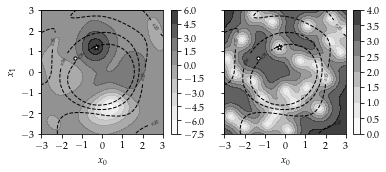

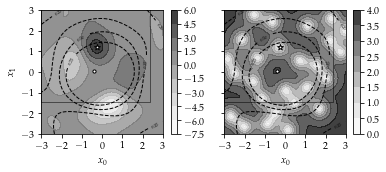

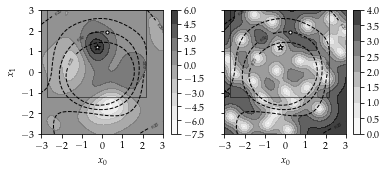

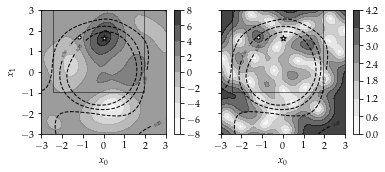

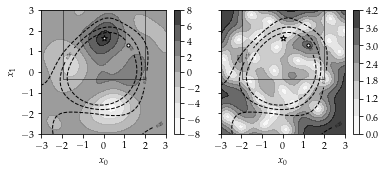

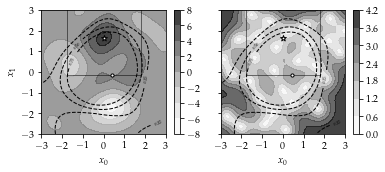

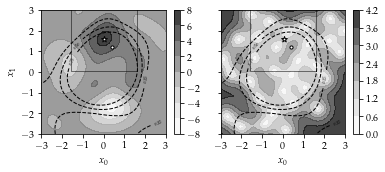

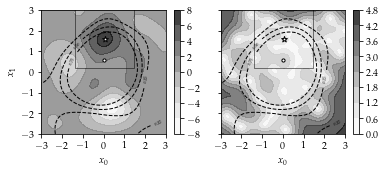

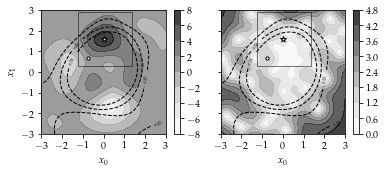

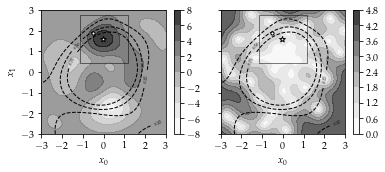

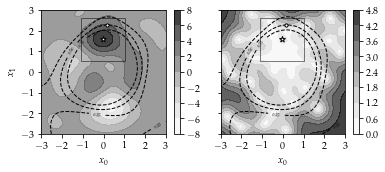

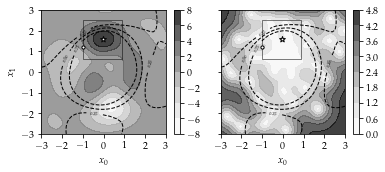

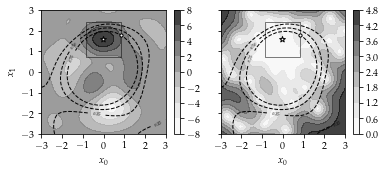

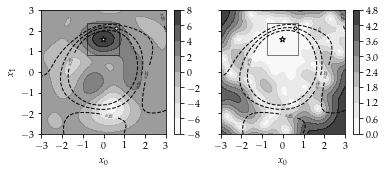

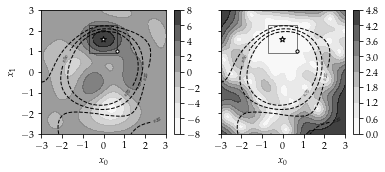

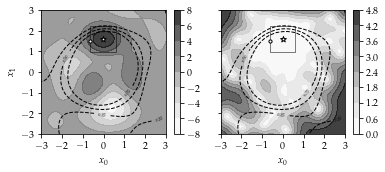

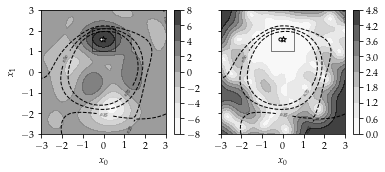

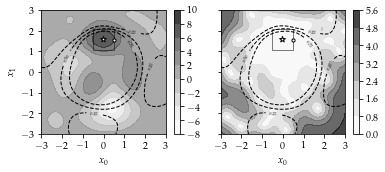

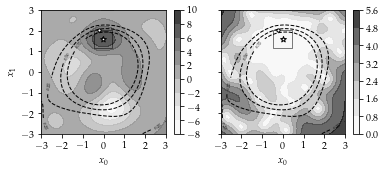

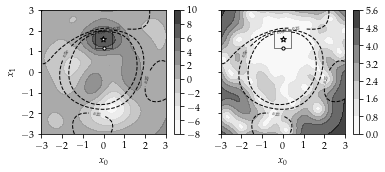

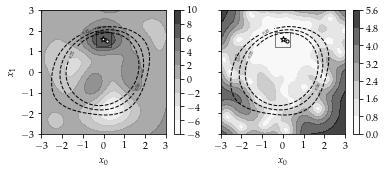

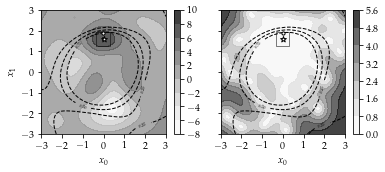

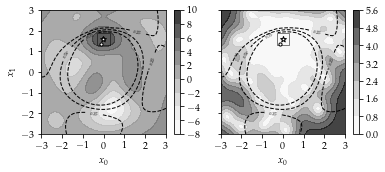

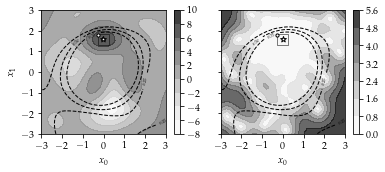

In [8]:
baron = pyo.SolverFactory('baron')
baron.options['NumLoc'] = 50
baron.options['MaxIter'] = 0

adb = copy.deepcopy(db)
agpr = copy.deepcopy(gpr)
agpc = copy.deepcopy(gpc)
aspace = copy.deepcopy(space)

results3 = gp_adaptive_dfo(aspace, adb, agpr, agpc, 50, baron, db3)
print(results3)

In [27]:
print(sum(results3.ttot))

265.02744340896606


1.668860916492449
0.8224545277821109


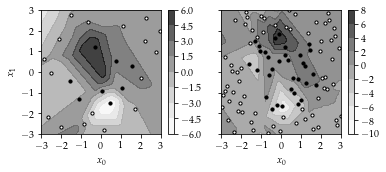

In [9]:
nnr = NN([2, 10, 10, 1], 'relu')
nnr.fit(db.scaled_inputs.to_numpy(), db.scaled_outputs.to_numpy(), iprint=0)
pred = nnr.predict(db.scale_inputs(db3.data[['x0', 'x1']]).to_numpy())
print(mean_absolute_error(db3.data.y[db3.data.t==1], db.inv_scale_outputs(pred)[db3.data.t==1]))

nnr2 = NN([2, 10, 10, 1], 'relu')
nnr2.fit(db2.scaled_inputs.to_numpy(), db2.scaled_outputs.to_numpy(), iprint=0)
pred = nnr2.predict(db2.scale_inputs(db3.data[['x0', 'x1']]).to_numpy())
print(mean_absolute_error(db3.data.y[db3.data.t==1], db2.inv_scale_outputs(pred)[db3.data.t==1]))

plot_nnr(db, db2, nnr, nnr2)
plt.savefig('../figures/nnr.png', dpi=500)

0.9556962025316456 0.825136612021858
0.9651162790697675 0.907103825136612


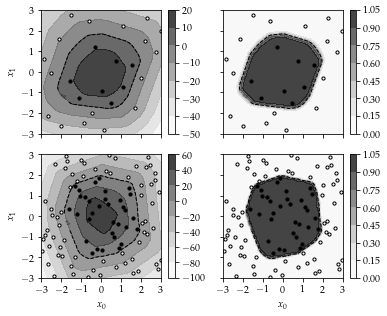

In [10]:
nnc = NN([2, 20, 1], 'relu', is_classifier=True)
nnc.fit(db.scaled_inputs.to_numpy(), db.data.t.to_numpy().reshape(-1, 1), iprint=0)
pred = nnc.predict(db.scale_inputs(db3.data[['x0', 'x1']]).to_numpy(), return_class=True)[1]
precision = precision_score(db3.data.t.to_numpy(), pred)
recall = recall_score(db3.data.t.to_numpy(), pred)
print(precision, recall)

nnc2 = NN([2, 20, 1], 'relu', is_classifier=True)
nnc2.fit(db2.scaled_inputs.to_numpy(), db2.data.t.to_numpy().reshape(-1, 1), iprint=0)
pred = nnc2.predict(db2.scale_inputs(db3.data[['x0', 'x1']]).to_numpy(), return_class=True)[1]
precision = precision_score(db3.data.t.to_numpy(), pred)
recall = recall_score(db3.data.t.to_numpy(), pred)
print(precision, recall)

plot_nnc(db, db2, nnc, nnc2)
plt.savefig('../figures/nnc.png', dpi=500)

In [11]:
def nn_algorithm_results(m, d, nn, testing, t):
    results = pd.Series(dtype='float64')
    x = np.fromiter(m.inputs.extract_values().values(), dtype=float).reshape(1, -1)
    results['x0*'] = d.inv_scale_inputs(x).ravel()[0]
    results['x1*'] = d.inv_scale_inputs(x).ravel()[1]
    results['obj'] = d.inv_scale_outputs(np.array(m.output.value).reshape(1, -1)).ravel()[0]
    results['lgt'] = m.prob.value
    results['err'] = mean_absolute_error(testing.data.y[testing.data.t==1], d.inv_scale_outputs(nn.predict(d.scale_inputs(testing.data[['x0', 'x1']]).to_numpy()))[testing.data.t==1])
    results['tsol'] = t[2] - t[1]
    results['ttot'] = t[2] - t[0]
    return results

def nn_global_dfo(db, nnr, nnc, solver, testing):
    times = [time.time()]
    omo = pyomo_problem(db.scaled_space, 0.0)

    nnr_block = MPBlock(nnr)
    nnc_block = MPBlock(nnc)
    omo.nnr = nnr_block.get_formulation()
    omo.nnc = nnc_block.get_formulation()

    omo.connectors = pyo.ConstraintList()
    omo.connectors.add(omo.output == omo.nnr.outputs[0])
    omo.connectors.add(omo.prob == omo.nnc.outputs[0])
    for i in omo.n_inputs:
        omo.connectors.add(omo.inputs[i] == omo.nnr.inputs[i])
        omo.connectors.add(omo.inputs[i] == omo.nnc.inputs[i])

    times.append(time.time())
    solver.solve(omo, tee=True)
    times.append(time.time())

    results = nn_algorithm_results(omo, db, nnr, testing, times)
    
    return results

 BARON version 22.9.30. Built: OSX-64 Fri Sep 30 09:08:44 EDT 2022

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Benoit Chachuat at Imperial College London, b.chachuat@imperial.ac.uk.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Kilinc, M. and N. V. Sahinidis, Exploiting integrality in the global
 optimization of mixed-integer nonlinear programming problems in BARON,
 Optimization Methods and Software, 33, 540-562, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC, ILOG CPLEX                             
 For NLP: IPOPT, FILTERSQP
 Doing local search
 Solving bounding LP
 Starting multi-start local search
 Done with local search
  Iteration    Open nodes         Time (s)    Lower bound      Upper bound
*         1             1             0.07      1.59698          5.06154
          1             0             0.07 

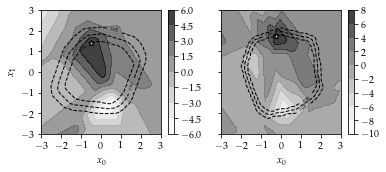

In [12]:
solver = pyo.SolverFactory('baron')
results4 = nn_global_dfo(db, nnr, nnc, solver, db3)
results5 = nn_global_dfo(db2, nnr2, nnc2, solver, db3)

plot_nn_opt(db, db2, nnr, nnr2, nnc, nnc2, results4[['x0*', 'x1*']], results5[['x0*', 'x1*']])
plt.savefig('../figures/nnopt.png', dpi=500)
print(results4)
print(results5)

In [13]:
def nn_adaptive_results(m, d, nn, testing, t):
    results = pd.DataFrame(index=[0], dtype='float64')
    x = np.fromiter(m.inputs.extract_values().values(), dtype=float).reshape(1, -1)
    results['x0*'] = d.inv_scale_inputs(x).ravel()[0]
    results['x1*'] = d.inv_scale_inputs(x).ravel()[1]
    results['obj'] = d.inv_scale_outputs(np.array(m.output.value).reshape(1, -1)).ravel()[0]
    results['lgt'] = m.prob.value    
    results['err'] = mean_absolute_error(testing.y[testing.t==1], d.inv_scale_outputs(nn.predict(d.scale_inputs(testing[['x0', 'x1']]).to_numpy()))[testing.t==1])
    results['tads'] = t[2] - t[1]
    results['tomo'] = t[4] - t[3]
    results['ttot'] = t[5] - t[0]
    return results


def nn_adaptive_dfo(space, d, nnr, nnc, max_iter, solver, testing, activation='relu'):
    for iteration in range(max_iter):
        times = [time.time()]
        
        nnr_block = MPBlock(nnr)
        nnc_block = MPBlock(nnc)
        
        omo = pyomo_problem(d.scale_space(space), 0.0)
        omo.nnr = nnr_block.get_formulation()
        omo.nnc = nnc_block.get_formulation()
        omo.connectors = pyo.ConstraintList()
        omo.connectors.add(omo.output == omo.nnr.outputs[0])
        omo.connectors.add(omo.prob == omo.nnc.outputs[0])
        for i in omo.n_inputs:
            omo.connectors.add(omo.inputs[i] == omo.nnr.inputs[i])
            omo.connectors.add(omo.inputs[i] == omo.nnc.inputs[i])
            
        ads = AdaptiveSampler(d.scale_space(space))
        mod = ads.max_triangle(d.scaled_inputs.to_numpy(), include_vertices=1)
        mod.nnc = nnc_block.get_formulation()
        mod.feas = pyo.Constraint(expr=mod.nnc.outputs[0] >= 0.0)
        mod.connectors = pyo.ConstraintList()
        for i in mod.n_inputs:
            mod.connectors.add( mod.inputs[i] == mod.nnc.inputs[i] )
        
        times.append(time.time())
        baron = pyo.SolverFactory('baron')
        res = baron.solve(mod, tee=False)
        times.append(time.time())
        
        ads_x = d.inv_scale_inputs(np.fromiter(mod.inputs.extract_values().values(), dtype=float).reshape(1, -1))
        ads_y = bb.sample_y(ads_x)
        ads_t = bb.sample_t(ads_x)
        
        times.append(time.time())
        res = solver.solve(omo, tee=False)
        times.append(time.time())

        x = d.inv_scale_inputs(np.fromiter(omo.inputs.extract_values().values(), dtype=float).reshape(1, -1))
        obj = d.inv_scale_outputs(np.array(omo.output.value).reshape(1, -1)).ravel()
        plot_nn_adaptive_opt(d, nnr, nnc, x.ravel(), ads_x.ravel(), space, ads)
        plt.savefig('../figures/nn_adaptive{}.png'.format(iteration), dpi=500)
        
        nnr = NN([2, 10, 10, 1], activation)
        nnr.fit(d.scaled_inputs.to_numpy(), d.scaled_outputs.to_numpy(), iprint=0)
        nnc = NN([2, 20, 1], activation, is_classifier=True)
        nnc.fit(d.scaled_inputs.to_numpy(), d.data.t.to_numpy().reshape(-1, 1), iprint=0)

        space = bt(d.space, space, 0.9, x.ravel(), 0.5)
        
        times.append(time.time())
        if iteration == 0:
            test_data = testing.data.loc[testing.data.x0 >= space[0][0]]
            test_data = test_data.loc[testing.data.x0 <= space[0][1]]
            test_data = test_data.loc[testing.data.x1 >= space[1][0]]
            test_data = test_data.loc[testing.data.x1 <= space[1][1]]
            results = nn_adaptive_results(omo, d, nnr, test_data, times)
        else:
            test_data = testing.data.loc[testing.data.x0 >= space[0][0]]
            test_data = test_data.loc[testing.data.x0 <= space[0][1]]
            test_data = test_data.loc[testing.data.x1 >= space[1][0]]
            test_data = test_data.loc[testing.data.x1 <= space[1][1]]
            results = pd.concat([results, nn_adaptive_results(omo, d, nnr, test_data, times)], ignore_index=1)
        
        d.data.loc[len(d.data), :] = [*ads_x[0], *ads_y[0], *ads_t[0]]
        
#         if convergence_check(space, 0.5) == 1:
#             break

        print(results['err'][len(results) - 1])

        if results['err'][len(results) - 1] < 0.1:
            break
        
    return results.T

shrinking dimension...
shrinking dimension...
1.5901017876736394
shrinking dimension...
shrinking dimension...
1.6940947604627445
shrinking dimension...
shrinking dimension...
1.5633942642986025
shrinking dimension...
shrinking dimension...
1.2194126028647694
shrinking dimension...
shrinking dimension...
1.4417715863997014
shrinking dimension...
shrinking dimension...
1.765616098721719
shrinking dimension...
shrinking dimension...
1.527391847490211
shrinking dimension...
lower bound active
1.85296024398033
shrinking dimension...
shrinking dimension...
1.5955844271673454
shrinking dimension...
shrinking dimension...
2.4102631293122494
shrinking dimension...
shrinking dimension...
1.0255899723501947
shrinking dimension...
upper bound active
0.7146444072254866
shrinking dimension...
shrinking dimension...
0.8463573602499272
shrinking dimension...
shrinking dimension...
0.5028867263222992
lower bound active
shrinking dimension...
0.99749666322489
shrinking dimension...
shrinking dimension.

/Users/alexdurkin/phd/examples/utils.py:367: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 2, figsize=(5.5, 2.5), sharex=True, sharey=True)


shrinking dimension...
shrinking dimension...
0.10954976004689095
shrinking dimension...
shrinking dimension...
0.47923954562716486
shrinking dimension...
shrinking dimension...
0.410600261441475
shrinking dimension...
shrinking dimension...
0.25082554402899915
shrinking dimension...
shrinking dimension...
0.22923244798551734
    model.name="unknown";
      - termination condition: other
      - message from solver: <undefined>
dimension converged
shrinking dimension...
0.36534774067833276
dimension converged
dimension converged
0.19211400046493327
dimension converged
dimension converged
0.08471421252663862
            0         1          2          3          4          5   \
x0*  -0.480831 -0.360929   0.000216  -0.058322  -0.133897  -0.125741   
x1*   1.384630  1.181901   0.603127   1.626711   1.218010   0.985935   
obj   5.777222  5.037182   7.189382  10.225386   7.274238   6.770422   
lgt   5.390748  8.774494  14.852839   4.056066  12.384732  14.857426   
err   1.590102  1.694095 

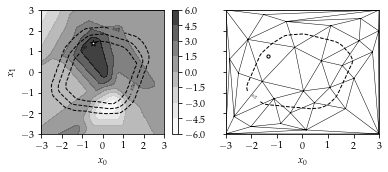

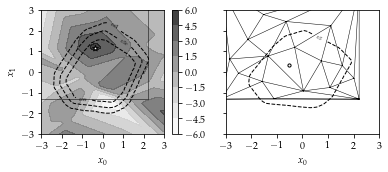

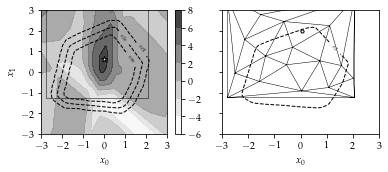

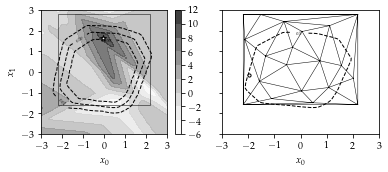

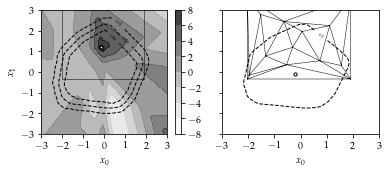

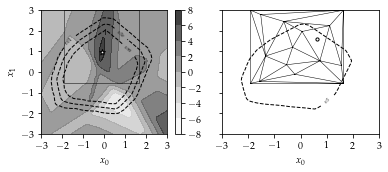

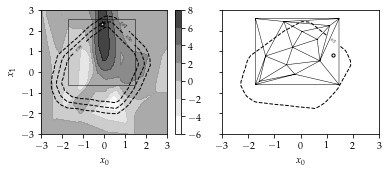

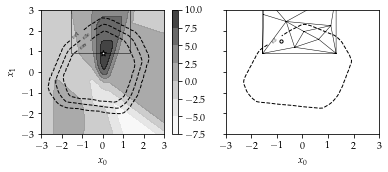

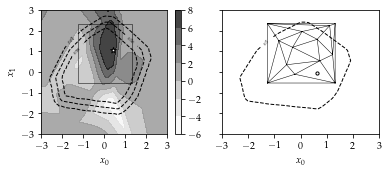

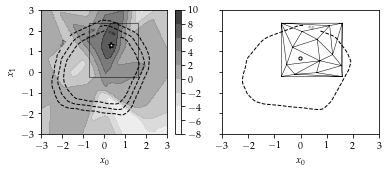

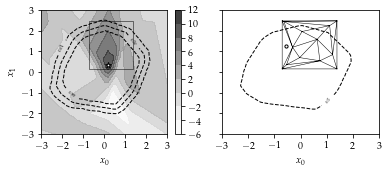

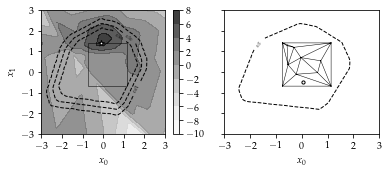

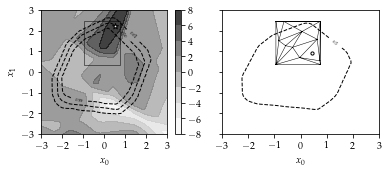

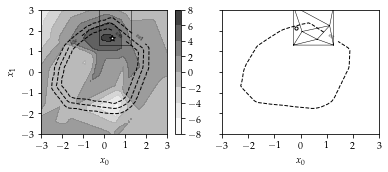

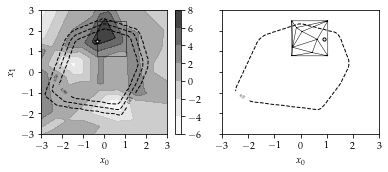

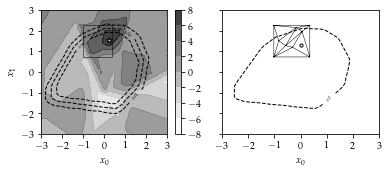

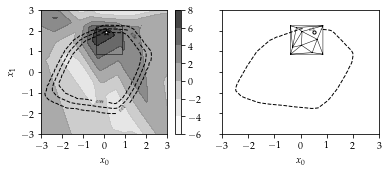

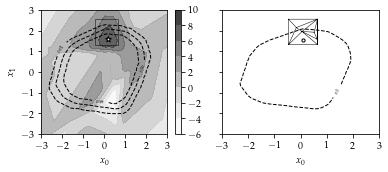

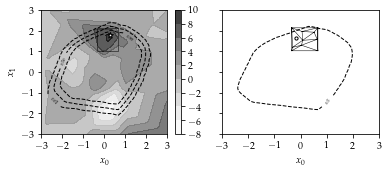

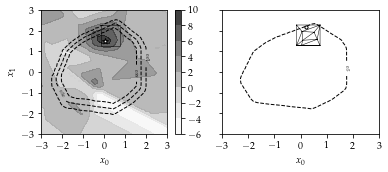

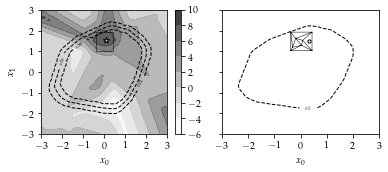

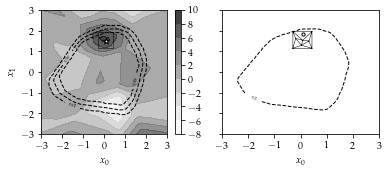

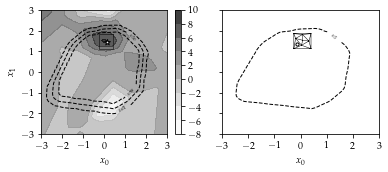

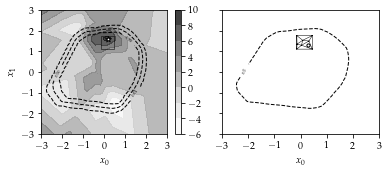

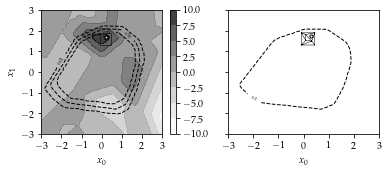

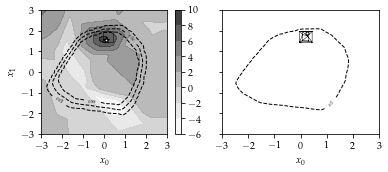

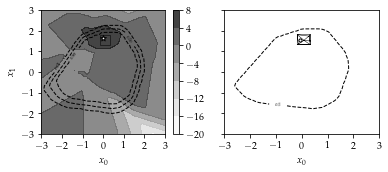

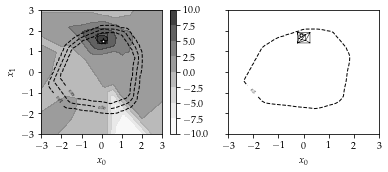

In [14]:
baron = pyo.SolverFactory('baron')

adb = copy.deepcopy(db)
annr = copy.deepcopy(nnr)
annc = copy.deepcopy(nnc)
aspace = copy.deepcopy(space)

results6 = nn_adaptive_dfo(aspace, adb, annr, annc, 50, baron, db3)
print(results6)

In [30]:
print(sum(results6.T.ttot))

116.29486775398254


In [16]:
def gp_bayesian_dfo(space, d, gpr, gpc, max_iter, solver, testing):
    for iteration in range(max_iter):
        times = [time.time()]
        
        gpr_block = MPBlock(gpr)
        gpc_block = MPBlock(gpc)
        
        omo = pyomo_problem(d.scale_space(space), 0.5)
        omo.gpr = gpr_block.get_formulation()
        omo.gpc = gpc_block.get_formulation()
        omo.connectors = pyo.ConstraintList()
        omo.connectors.add(omo.output == omo.gpr.outputs[0])
        omo.connectors.add(omo.prob == omo.gpc.outputs[0])
        for i in omo.n_inputs:
            omo.connectors.add(omo.inputs[i] == omo.gpr.inputs[i])
            omo.connectors.add(omo.inputs[i] == omo.gpc.inputs[i])
            
        ads = AdaptiveSampler(d.scale_space(space))
        mod = ads.modified_expected_improvement(gpr, d.scaled_outputs.to_numpy(), 'max')
        mod.gpc = gpc_block.get_formulation()
        mod.feas = pyo.Constraint(expr=mod.gpc.outputs[0] >= 0.5)
        mod.connectors = pyo.ConstraintList()
        for i in mod.n_inputs:
            mod.connectors.add( mod.inputs[i] == mod.gpc.inputs[i] )
        
        times.append(time.time())
        res = solver.solve(mod, tee=False)
        times.append(time.time())
        
        ads_x = d.inv_scale_inputs(np.fromiter(mod.inputs.extract_values().values(), dtype=float).reshape(1, -1))
        ads_y = bb.sample_y(ads_x)
        ads_t = bb.sample_t(ads_x)
        
        times.append(time.time())
        res = solver.solve(omo, tee=False)
        times.append(time.time())

        x = d.inv_scale_inputs(np.fromiter(omo.inputs.extract_values().values(), dtype=float).reshape(1, -1))
        obj = d.inv_scale_outputs(np.array(omo.output.value).reshape(1, -1)).ravel()
        ystar = np.max(d.scaled_outputs.to_numpy())
        plot_bayesian_opt(d, gpr, gpc, x.ravel(), ads_x.ravel(), ystar)
        plt.savefig('../figures/gp_bayesian{}.png'.format(iteration), dpi=500)

        gpr = GPR()
        gpr.fit(d.scaled_inputs.to_numpy(), d.scaled_outputs.to_numpy(), iprint=0)
        gpc = GPC()
        gpc.fit(d.scaled_inputs.to_numpy(), d.data.t.to_numpy().reshape(-1, 1), iprint=0)
    
        times.append(time.time())
        
        if iteration == 0:
            results = gp_adaptive_results(omo, d, gpr, testing.data, times)
        else:
            results = pd.concat([results, gp_adaptive_results(omo, d, gpr, testing.data, times)], axis=1, ignore_index=1)
        
        d.data.loc[len(d.data), :] = [*ads_x[0], *ads_y[0], *ads_t[0]]
        
        if mod.mod_ei.value < 0.01:
            print('modified expected improvement converged')
            break
        
    return results.T

modified expected improvement converged
        x0*       x1*       obj      prob       err       unc      tads  \
0 -0.319358  1.222064  5.382650  0.752507  1.176099  0.208237  2.209131   
1 -0.316725  1.276837  7.219982  0.752507  0.666760  0.434216  1.610628   
2 -0.014379  1.699781  9.429927  0.739293  0.635586  0.371866  1.457330   
3  0.055063  1.602709  8.750285  0.830490  0.593749  0.316603  1.337321   
4  0.047276  1.597495  8.569826  0.851068  0.573026  0.203489  1.905301   
5  0.037729  1.583685  8.552895  0.869813  0.533549  0.083224  2.866887   
6 -0.034140  1.618042  8.423487  0.872002  0.513612  0.012296  2.475927   
7 -0.025392  1.616343  8.319956  0.887444  0.565720  0.006264  2.741353   

       tomo      ttot  
0  1.457034  4.727316  
1  1.332385  4.385054  
2  0.827290  3.191111  
3  0.792295  3.128464  
4  1.157638  4.324327  
5  1.437377  5.557053  
6  1.331221  4.830223  
7  1.192884  5.071932  


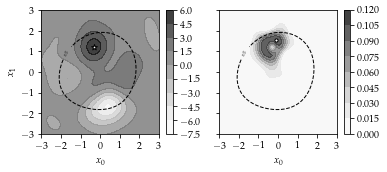

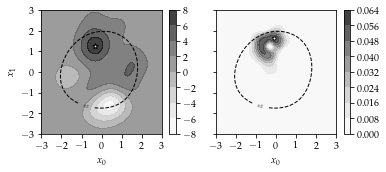

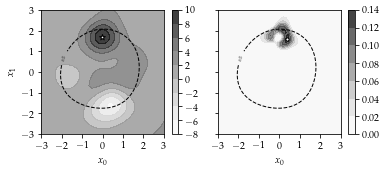

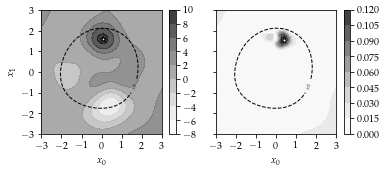

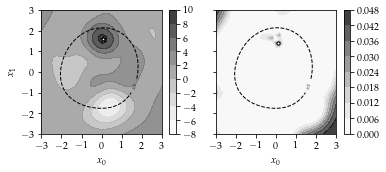

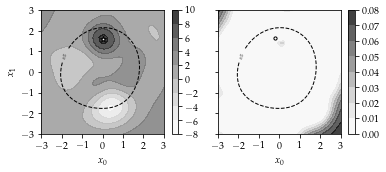

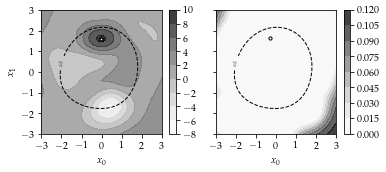

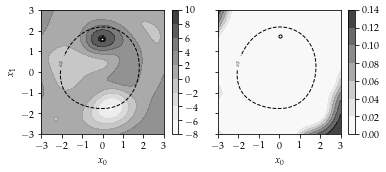

In [17]:
baron = pyo.SolverFactory('baron')
baron.options['NumLoc'] = 50
baron.options['MaxIter'] = 0

adb = copy.deepcopy(db)
agpr = copy.deepcopy(gpr)
agpc = copy.deepcopy(gpc)
aspace = copy.deepcopy(space)

results7 = gp_bayesian_dfo(aspace, adb, agpr, agpc, 50, baron, db3)
print(results7)

In [31]:
print(sum(results7.ttot))

35.21548008918762


In [18]:
def direct_search_results(m, d, t):
    results = pd.Series(dtype='float64')
    x = np.fromiter(m.inputs.extract_values().values(), dtype=float).reshape(1, -1)
    results['x0*'] = d.inv_scale_inputs(x).ravel()[0]
    results['x1*'] = d.inv_scale_inputs(x).ravel()[1]
    results['obj'] = np.max(d.data.y.to_numpy())
    results['lgt'] = m.clf.outputs[0].value
    results['tads'] = t[2] - t[1]
    results['tomo'] = t[4] - t[3]
    results['ttot'] = t[5] - t[0]
    return results

def direct_search_dfo(space, d, clf, max_iter, solver, testing):
    results = {}
    for iteration in range(max_iter):
        times = [time.time()]
        
        ads = AdaptiveSampler(d.scale_space(space))
        clf_block = MPBlock(clf)

        omo = ads.exploit_triangle(d.scaled_inputs.to_numpy(), d.scaled_outputs.to_numpy(), 'max', include_vertices=0)
        omo.clf = clf_block.get_formulation()
        omo.feas = pyo.Constraint(expr=omo.clf.outputs[0] >= 0.0)
        omo.connectors = pyo.ConstraintList()
        for i in omo.n_inputs:
            omo.connectors.add( omo.inputs[i] == omo.clf.inputs[i] )
            
        mod = ads.max_triangle(d.scaled_inputs.to_numpy(), include_vertices=0)
        mod.clf = clf_block.get_formulation()
        mod.feas = pyo.Constraint(expr=mod.clf.outputs[0] >= 0.0)
        mod.connectors = pyo.ConstraintList()
        for i in mod.n_inputs:
            mod.connectors.add( mod.inputs[i] == mod.clf.inputs[i] )
        
        times.append(time.time())
        res = solver.solve(mod, tee=False)
        times.append(time.time())
        
        ads_x = d.inv_scale_inputs(np.fromiter(mod.inputs.extract_values().values(), dtype=float).reshape(1, -1))
        ads_y = bb.sample_y(ads_x)
        ads_t = bb.sample_t(ads_x)
        
        times.append(time.time())
        res = solver.solve(omo, tee=False)
        times.append(time.time())

        x = d.inv_scale_inputs(np.fromiter(omo.inputs.extract_values().values(), dtype=float).reshape(1, -1))
        plot_direct_search(d, clf, x.ravel(), ads_x.ravel(), ads)
        plt.savefig('../figures/direct_search{}.png'.format(iteration), dpi=500)
        
        times.append(time.time())
        
        if iteration == 0:
            results = direct_search_results(omo, d, times)
        else:
            results = pd.concat([results, direct_search_results(omo, d, times)], axis=1, ignore_index=1)
        
        d.data.loc[len(d.data), :] = [*ads_x[0], *ads_y[0], *ads_t[0]]
        d.data.loc[len(d.data), :] = [*x[0], *bb.sample_y(x)[0], *bb.sample_t(x)[0]]
        clf = NN([2, 20, 1], 'relu', is_classifier=True)
        clf.fit(d.scaled_inputs.to_numpy(), d.data.t.to_numpy().reshape(-1, 1), iprint=0)
        
        if iteration > 0:
            x_dist = np.sqrt(sum((results[iteration][i] - results[iteration - 1][i]) ** 2 for i in ['x0*', 'x1*']))
            if x_dist < 0.01:
                print('direct search converged')
                break
        
    return results.T

/Users/alexdurkin/phd/examples/utils.py:439: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(4, 3))


direct search converged
         x0*       x1*       obj        lgt      tads      tomo      ttot
0  -1.334505  0.769815  5.374909   3.864517  0.058862  0.051604  0.463874
1  -0.532053  0.348223  5.374909  18.035220  0.054176  0.051504  0.535089
2   0.516119  1.324938  5.374909   5.865805  0.050977  0.049419  0.396833
3  -0.139879  1.653101  5.448344   4.808074  0.052924  0.053029  0.614767
4   0.496404  1.740030  7.882904   3.896113  0.050216  0.050298  0.397000
5  -0.602819  1.480393  7.882904   6.134489  0.058252  0.060059  0.420029
6  -0.092073  1.944729  7.882904   2.827000  0.052745  0.054362  0.425505
7   0.024409  1.390449  7.882904  17.754215  0.059953  0.055052  0.409299
8  -0.348571  1.442267  7.882904  10.886827  0.055020  0.057388  0.434174
9   0.126978  1.594526  7.882904  16.491578  0.055035  0.056245  0.411929
10  0.177103  1.759762  7.956389  11.721673  0.055628  0.056444  0.408426
11  0.379834  1.553165  7.956389  14.948479  0.061900  0.059095  0.425235
12  0.003836  

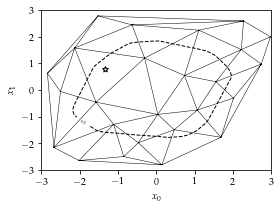

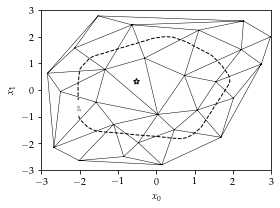

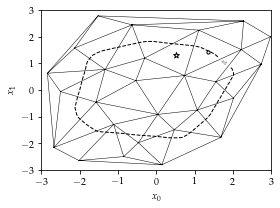

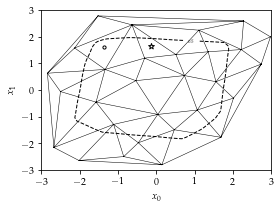

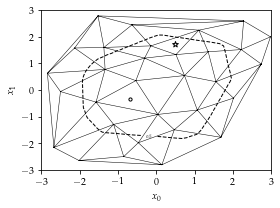

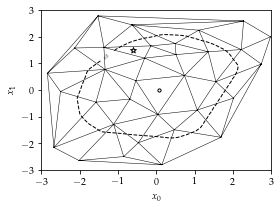

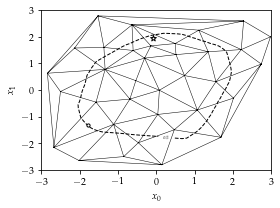

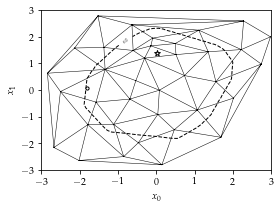

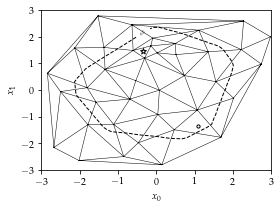

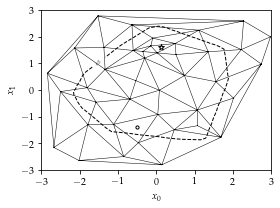

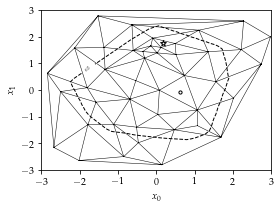

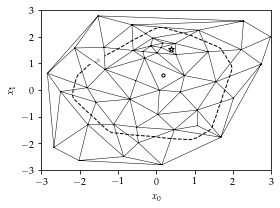

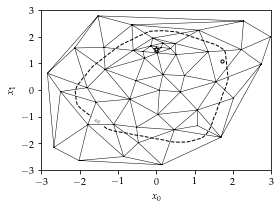

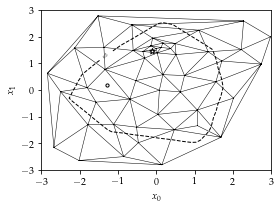

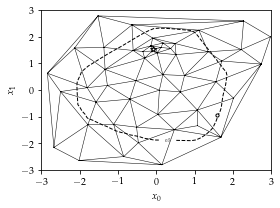

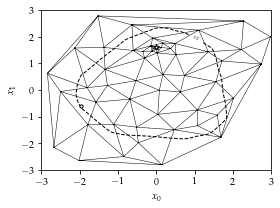

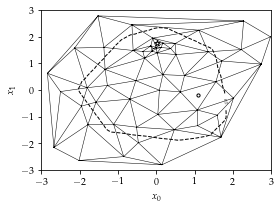

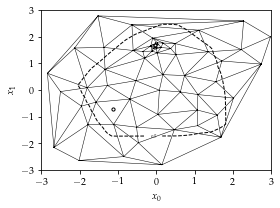

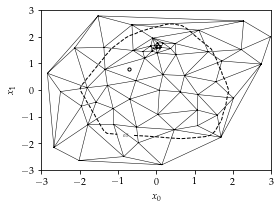

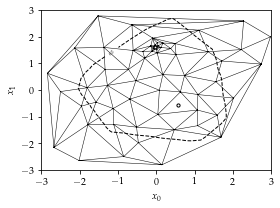

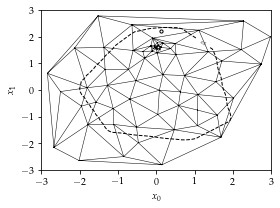

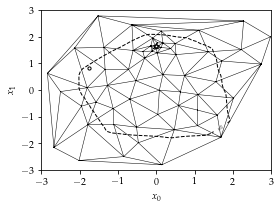

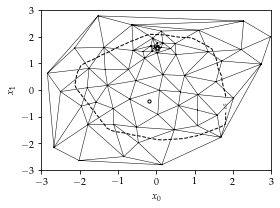

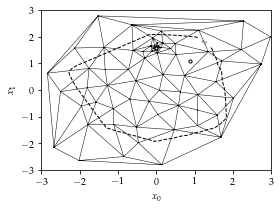

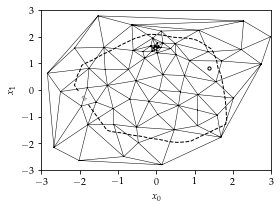

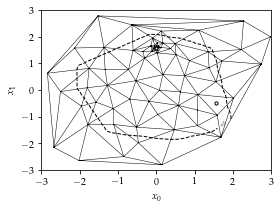

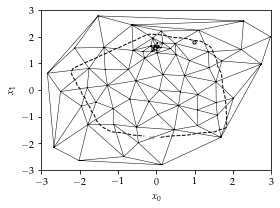

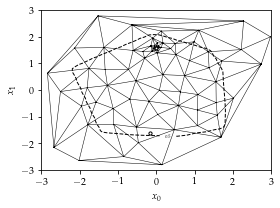

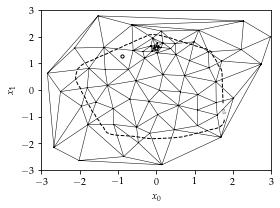

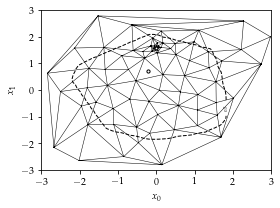

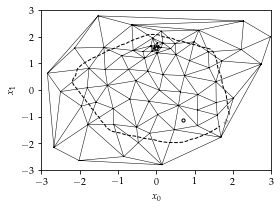

In [19]:
baron = pyo.SolverFactory('baron')

adb = copy.deepcopy(db)
annc = copy.deepcopy(nnc)
aspace = copy.deepcopy(space)

results8 = direct_search_dfo(aspace, adb, annc, 50, baron, db3)
print(results8)

In [20]:
print(results1)
print(results2)
print(results3)
print(results4)
print(results5)
print(results6)
print(results7)
print(results8)

x0*     -0.319358
x1*      1.222064
obj      5.382650
prob     0.752507
err      1.176099
unc      0.208237
tsol    20.604901
ttot    20.658472
dtype: float64
x0*       0.004403
x1*       1.583060
obj       8.152447
prob      0.947908
err       0.064589
unc       0.072891
tsol    511.776427
ttot    512.600568
dtype: float64
         x0*       x1*       obj      prob       err       unc       tads  \
0  -0.319358  1.222064  5.382650  0.752507  1.227087  0.208237   0.795415   
1  -0.267178  1.227006  5.400979  0.810270  1.123985  0.350258   1.081796   
2  -0.258459  1.229760  5.406628  0.810036  1.138347  0.373391   1.030688   
3   0.018141  1.631135  6.733741  0.882996  0.776115  1.232868   1.137427   
4   0.006736  1.637698  6.730910  0.878367  0.711718  1.180324   2.217289   
5   0.019737  1.628155  6.764457  0.894036  0.706817  1.113989   1.850471   
6   0.041652  1.618488  6.736712  0.898260  0.790774  1.217501   1.856705   
7   0.058032  1.595297  6.824646  0.905816  0.846440  0.92

AttributeError: 'DataFrame' object has no attribute 'ttot'

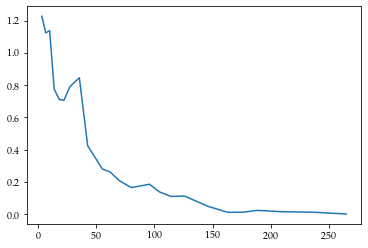

In [21]:
plt.plot(np.cumsum(results3.ttot), results3.err)
plt.plot(np.cumsum(results6.ttot), results6.err)
plt.plot(np.cumsum(results7.ttot), results7.err)

print(results1.err, results1.ttot)
print(results2.err, results2.ttot)

print(results4.err, results4.ttot)
print(results5.err, results5.ttot)

print(sum(results8.ttot))

In [ ]:
plt.plot(np.cumsum(results3.ttot), results3.obj)
plt.plot(np.cumsum(results6.ttot), results6.obj)
plt.plot(np.cumsum(results7.ttot), results7.obj)
plt.plot(np.cumsum(results8.ttot), results8.obj)
plt.scatter(results1.ttot, results1.obj)

print(results1.obj, results1.ttot)
print(results2.obj, results2.ttot)

print(results4.obj, results4.ttot)
print(results5.obj, results5.ttot)